# Demographic, Economic & Behavioral Data Analysis and Exploration

## Introduction

<img src='clinton_trump.jpg'/>

In this notebook we analyze a few demographic and social factors for the USA, such as:

* Population
* Electoral Votes
* Fraction of Republicans in 2016
* Fraction of Democrats in 2016
* Amount of Votes
* Amount of Votes for Trump
* Amount of Votes for Hillary
* Education
* Race
* Professional Occupations
* Obesity
* Diabetes
* Health Insurance
* Unemployment

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as r
import lxml.html as html
import bs4 as bs
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plt.style.use('ggplot')

import sys
sys.path.append('../../libs/')

import DSF_helpers

init_notebook_mode(connected=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Religion per State

### Reading our Dataset

In [2]:
with open(r'data/religions.html', "r") as f:
    page = f.read()
    
tree = html.fromstring(page)
df_religion = pd.read_html('data/religions.html')[0]

### Basic Data Cleaning

In [3]:
df_religion.columns = ['state', 'percentage'] #Define column names
df_religion['state'] = df_religion.state.str.replace(r'[0-9]+\.', '', regex=True) #Clean state names
df_religion['percentage'] = (df_religion['percentage'].str.replace('%', '')).astype(int) / 100 #Convert into decimal
df_religion['code'] = df_religion.state.str.strip().apply(lambda x: DSF_helpers.state_name_to_abrv(x)) #Create Abbrev

In [4]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale = True,
        locations = df_religion['code'],
        z = df_religion['percentage'].astype(float),
        locationmode = 'USA-states',
        text = df_religion['code'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "% Religious")
        ) ]

layout = dict(
        title = 'USA Percentage of Religious People per State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

<img src="Religion_USA_Plot.png" />

## Comments

* Southeast states are more religious - the so-called **bible-belt**
* We would expect these areas to be Trump supporters
* On the other hand, southwest and northwest are less religious; Northeast is almost non-religious
* Midwest and mideast are mixed

In [5]:
df_religion.to_csv("usa_religion_per_state.csv")

## Education

### Reading our Dataset

In [6]:
df_education = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment', header=0)[0]
df_education.head()

,State,% High school graduate,Rank,% Bachelor's degree,Rank.1,% Advanced degree,Rank.2
0,Tennessee,93.6%,2.0,29.5%,20.0,9.5%,32.0
1,Minnesota,92.4%,2.0,33.7%,10.0,11.2%,17.0
2,New Hampshire,92.3%,3.0,34.9%,8.0,13.0%,9.0
3,Wyoming,92.3%,3.0,25.7%,40.0,8.6%,40.0
4,Alaska,92.1%,5.0,28.0%,26.0,10.1%,27.0


### Basic Cleaning

In [7]:
df_education['code'] = df_education.State.str.strip().apply(lambda x: DSF_helpers.state_name_to_abrv(x))
df_education['% High school graduate'] = (df_education['% High school graduate'].str.replace('%', '')).astype(float) / 100
df_education["% Bachelor's degree"] = (df_education["% Bachelor's degree"].str.replace('%', '')).astype(float) / 100
df_education['% Advanced degree'] = (df_education['% Advanced degree'].str.replace('%', '')).astype(float) / 100
df_education = df_education.drop(['Rank', 'Rank.1', 'Rank.2'], axis=1)

## Visualization

In [8]:
df_education = df_education.set_index('code')

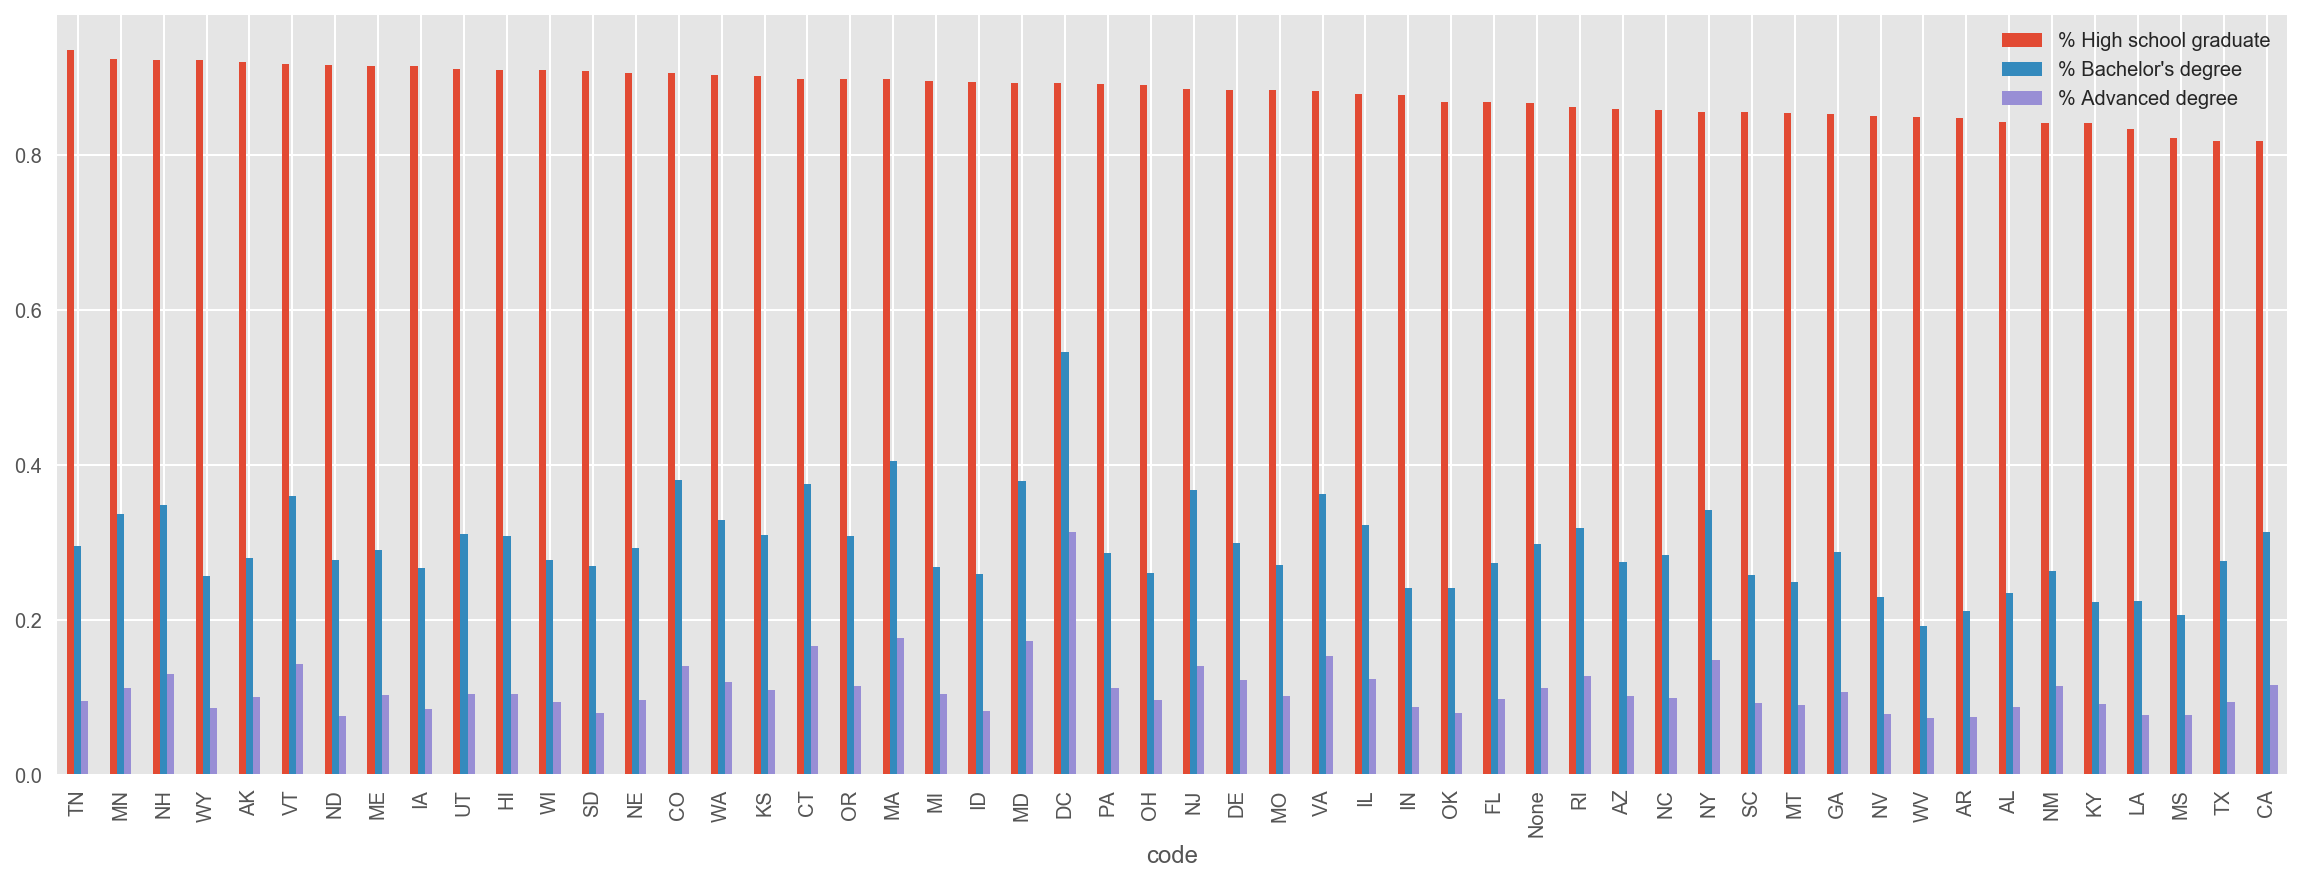

In [9]:
df_education = df_education.dropna()
df_education.plot(kind='bar', legend=True, figsize=(20,7))

In [10]:
df_education = df_education.reset_index()

## Comments

* High school levels are mostly homogeneous across the country
* Bachelor's and Advanced Degrees is more dispersed across the states
* We would expect some correlation between education and religion

## Analyzing Education vs. Religion

In [11]:
df_merged = pd.merge(left=df_religion, right=df_education, on='code').dropna()

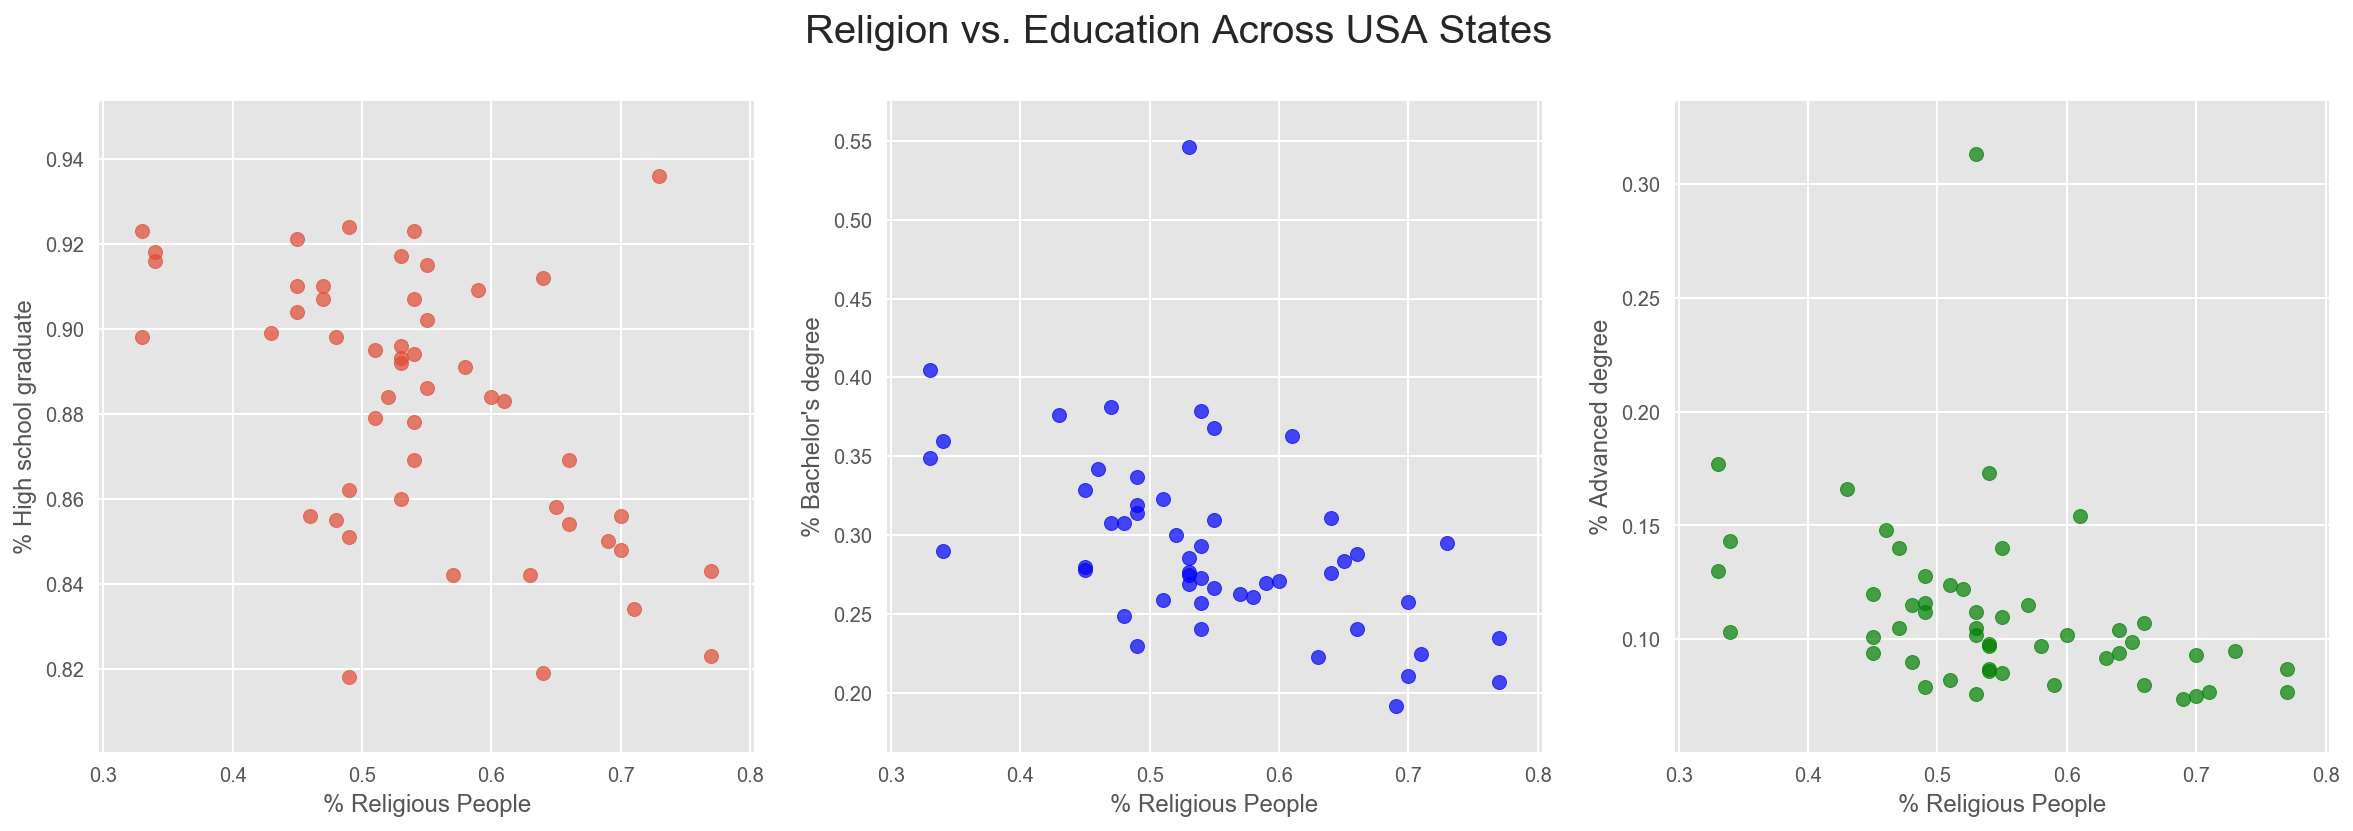

In [12]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

fig.suptitle('Religion vs. Education Across USA States', fontsize=20)

ax[0].scatter(df_merged.percentage, df_merged["% High school graduate"], alpha=0.7)
ax[1].scatter(df_merged.percentage, df_merged["% Bachelor's degree"], alpha=0.7, color='blue')
ax[2].scatter(df_merged.percentage, df_merged["% Advanced degree"], alpha=0.7, color='green')

ax[0].set_xlabel("% Religious People")
ax[1].set_xlabel("% Religious People")
ax[2].set_xlabel("% Religious People")

ax[0].set_ylabel("% High school graduate")
ax[1].set_ylabel("% Bachelor's degree")
ax[2].set_ylabel("% Advanced degree")

In [13]:
df_merged = df_merged.rename(columns={'percentage': 'percentage_religious'})

In [14]:
df_merged.to_csv('dataset_religion_education.csv')

## Unemployment

In [15]:
df_unemployment = pd.read_html('https://www.bls.gov/lau/lastrk16.htm')[0].dropna().reset_index().drop('index', axis=1)
df_unemployment['code'] = df_unemployment['State'].apply(lambda x: DSF_helpers.state_name_to_abrv(x))

In [16]:
df_unemployment.head()

,State,2016rate,Rank,code
0,Hawaii,2.9,1.0,HI
1,New Hampshire,2.9,1.0,NH
2,South Dakota,3.0,3.0,SD
3,Nebraska,3.1,4.0,NE
4,North Dakota,3.1,4.0,ND


In [17]:
df_unemployment = df_unemployment.rename(columns={'2016rate': '2016_unemployment_rate'})

In [18]:
df_merged = pd.merge(df_merged, df_unemployment.loc[:,['code', '2016_unemployment_rate']], on='code')

In [19]:
df_merged.head()

,state,percentage_religious,code,State,% High school graduate,% Bachelor's degree,% Advanced degree,2016_unemployment_rate
0,Alabama,0.77,AL,Alabama,0.843,0.235,0.087,5.9
1,Mississippi,0.77,MS,Mississippi,0.823,0.207,0.077,5.8
2,Tennessee,0.73,TN,Tennessee,0.936,0.295,0.095,4.7
3,Louisiana,0.71,LA,Louisiana,0.834,0.225,0.077,6.0
4,Arkansas,0.70,AR,Arkansas,0.848,0.211,0.075,3.9


## Campaign Rallies

In [20]:
clinton_url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/presidential-campaign-trail/clinton.csv'
trump_url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/presidential-campaign-trail/trump.csv'

df_clinton_rallies = pd.read_csv(clinton_url)
df_trump_rallies = pd.read_csv(trump_url)

df_clinton_rallies['date'] = pd.to_datetime(df_clinton_rallies['date'])
df_trump_rallies['date'] = pd.to_datetime(df_trump_rallies['date'])

df_clinton_rallies = df_clinton_rallies[df_clinton_rallies.date < '2017-10-01']
df_trump_rallies = df_trump_rallies[df_trump_rallies.date < '2017-10-01']

In [21]:
df_clinton_rallies.head()

,date,location,lat,lng
0,2016-09-05,"Cleveland, Ohio",41.499320,-81.694361
1,2016-09-05,"Hampton, Illinois",41.555867,-90.409297
2,2016-09-06,"Tampa, Florida",27.950575,-82.457178
3,2016-09-07,"New York City, New York",40.712784,-74.005941
4,2016-09-08,"Charlotte, North Carolina",35.227087,-80.843127


In [22]:
#df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
#colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 5000

for i in range(len(limits)):
    lim = limits[i]
    #df_sub = df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_trump_rallies['lng'],
        lat = df_trump_rallies['lat'],
        text = df_trump_rallies['location'],
        marker = dict(
            size = 100000/scale,
            # sizeref = 2. * max(df_sub['pop']/scale) / (25 ** 2),
            color = 'rgba(255,0,0,0.3)',
            opacity = 0.3,
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

for i in range(len(limits)):
    lim = limits[i]
    #df_sub = df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_clinton_rallies['lng'],
        lat = df_clinton_rallies['lat'],
        text = df_clinton_rallies['location'],
        marker = dict(
            size = 100000/scale,
            # sizeref = 2. * max(df_sub['pop']/scale) / (25 ** 2),
            color = 'rgba(0,0,255,0.3)',
            opacity = 0.3,
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = dict(
        title = '2016 Election Rallies',
        showlegend = False,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=cities, layout=layout)
iplot(fig, validate=False, filename='d3-bubble-map-populations')

<img src='Rallies.png'/>

In [23]:
df_clinton_rallies['code'] = df_clinton_rallies.location.str.extract(r', (.*)')
df_clinton_rallies['code'] = df_clinton_rallies.code.apply(lambda x: DSF_helpers.state_name_to_abrv(x))

df_trump_rallies['code'] = df_trump_rallies.location.str.extract(r', (.*)')

In [24]:
df_trump_rallies.head()

,date,location,lat,lng,code
0,2016-09-01,"Wilmington, OH",39.445339,-83.828537,OH
1,2016-09-03,"Detroit, MI",42.331427,-83.045754,MI
2,2016-09-06,"Virginia Beach, VA",36.852926,-75.977985,VA
3,2016-09-06,"Greenville, NC",35.612661,-77.366354,NC
4,2016-09-07,"New York, NY",40.712784,-74.005941,NY


In [25]:
df_grouped_clinton = df_clinton_rallies[df_clinton_rallies.date < '2016-10-01'].groupby('code').count().location.reset_index()
df_grouped_trump = df_trump_rallies[df_trump_rallies.date < '2016-10-01'].groupby('code').count().location.reset_index()

df_grouped_clinton.columns = ['code', 'rallies_clinton']
df_grouped_trump.columns = ['code', 'rallies_trump']

In [26]:
df_merged = pd.merge(df_merged, df_grouped_clinton, on='code', how='left')
df_merged = pd.merge(df_merged, df_grouped_trump, on='code', how='left')
df_merged = df_merged.fillna(0)

In [27]:
df_merged

,state,percentage_religious,code,State,% High school graduate,% Bachelor's degree,% Advanced degree,2016_unemployment_rate,rallies_clinton,rallies_trump
0,Alabama,0.77,AL,Alabama,0.843,0.235,0.087,5.9,0.0,0.0
1,Mississippi,0.77,MS,Mississippi,0.823,0.207,0.077,5.8,0.0,0.0
2,Tennessee,0.73,TN,Tennessee,0.936,0.295,0.095,4.7,0.0,0.0
3,Louisiana,0.71,LA,Louisiana,0.834,0.225,0.077,6.0,0.0,0.0
4,Arkansas,0.70,AR,Arkansas,0.848,0.211,0.075,3.9,0.0,0.0
5,South Carolina,0.70,SC,South Carolina,0.856,0.258,0.093,5.0,0.0,0.0
6,West Virginia,0.69,WV,West Virginia,0.850,0.192,0.074,6.1,0.0,0.0
7,Oklahoma,0.66,OK,Oklahoma,0.869,0.241,0.080,4.8,0.0,0.0
8,Georgia,0.66,GA,Georgia,0.854,0.288,0.107,5.4,0.0,0.0
9,North Carolina,0.65,NC,North Carolina,0.858,0.284,0.099,5.1,3.0,4.0


In [28]:
df_merged.to_csv('demographics_dataset_1.0.csv')

## More Data

The dataset below contains:

* Population
* Electoral Votes
* Fraction of Republicans in 2016
* Fraction of Democrats in 2016
* Amount of Votes
* Amount of Votes for Trump
* Amount of Votes for Hillary
* Education
* Race
* Professional Occupations
* Obesity
* Diabetes
* Health Insurance
* Unemployment

The primary dataset was aggregated from county level info, so all ratios are averages of county percentages. For example, Texas is listed as having an uninsured rate of 26.6%. Here, this means that the "average" or typical Texas county has 26.6% people uninsured, NOT that 26.6% of all Texans are uninsured.

This caveat is not true of the democratic/republican vote percentages, which were taken directly from the <a href='http://www.politico.com/2016-election/results/map/president'>Politico elections result report.</a>

The remaining data was collected by the New York Times and The Ulster Institute for Social Research for a publication in the Open Quantitative Sociology & Political Science journal in 2016.

Also included are extracts from the 2015 Census Data datasets for income, poverty, and race that were joined to the elections data set during analysis. The sources for these extracts can be found on the <a href='https://data.world/uscensusbureau'>U.S. Census Bureau's data.world profile</a>.

In [29]:
df_expanded = pd.read_csv('../../../../../Downloads/1ElectionsData.csv')

In [30]:
df_expanded.columns

Index(['State', 'Region', 'Total.Population', 'electoralvotes', 'rep16_frac',
       'dem16_frac', 'votes', 'votes16_trumpd', 'votes16_clintonh',
       'votes16_johnsong', 'votes16_steinj', 'At.Least.Bachelor.s.Degree',
       'At.Least.High.School.Diploma', 'Less.Than.High.School',
       'Graduate.Degree', 'White.not.Latino.Population',
       'African.American.Population', 'Native.American.Population',
       'Asian.American.Population', 'Population.some.other.race.or.races',
       'Latino.Population', 'Management.professional.and.related.occupations',
       'Service.occupations', 'Sales.and.office.occupations',
       'Farming.fishing.and.forestry.occupations',
       'Construction.extraction.maintenance.and.repair.occupations',
       'Production.transportation.and.material.moving.occupations',
       'Adult.obesity', 'Diabetes', 'Uninsured', 'Unemployment'],
      dtype='object')

In [31]:
df_expanded['code'] = df_expanded.State.apply(lambda x: DSF_helpers.state_name_to_abrv(x))

In [32]:
df_expanded.head()

,State,Region,Total.Population,electoralvotes,rep16_frac,dem16_frac,votes,votes16_trumpd,votes16_clintonh,votes16_johnsong,...,Service.occupations,Sales.and.office.occupations,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,code
0,Alabama,South,4706548.0,9,0.629000,0.346000,2078165,1306925,718084,43869,...,15.726119,23.541045,1.416418,12.050746,21.281343,0.350821,0.140821,0.174149,0.085701,AL
1,Alaska,West,696686.5,3,0.529000,0.377000,249484,130656,95511,14697,...,16.708621,21.448276,2.839655,11.675862,14.631034,0.298833,0.072625,0.276000,0.094083,AK
2,Arizona,West,6358441.0,11,0.495000,0.454000,2062810,1021154,936250,80151,...,20.876667,24.660000,1.566667,13.316667,10.410000,0.278067,0.100800,0.205333,0.114067,AZ
3,Arkansas,South,2877030.5,6,0.681466,0.318534,1121684,677904,378729,29518,...,16.844000,22.377333,2.529333,11.146000,21.049333,0.336160,0.124547,0.209827,0.082240,AR
4,California,West,36781241.5,55,0.328000,0.616000,11954317,3916209,7362490,402406,...,19.116379,23.932759,3.515517,9.853448,10.617241,0.242190,0.080776,0.189552,0.122517,CA


In [33]:
#df_expanded = df_expanded.set_index('code')
#df_merged = df_merged.set_index('code')

df_merged = pd.merge(df_expanded, df_merged.loc[:, ['percentage_religious', 'rallies_clinton', 'rallies_trump']], left_index=True, right_index=True)

In [34]:
df_merged.head()

,State,Region,Total.Population,electoralvotes,rep16_frac,dem16_frac,votes,votes16_trumpd,votes16_clintonh,votes16_johnsong,...,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,code,percentage_religious,rallies_clinton,rallies_trump
0,Alabama,South,4706548.0,9,0.629000,0.346000,2078165,1306925,718084,43869,...,12.050746,21.281343,0.350821,0.140821,0.174149,0.085701,AL,0.77,0.0,0.0
1,Alaska,West,696686.5,3,0.529000,0.377000,249484,130656,95511,14697,...,11.675862,14.631034,0.298833,0.072625,0.276000,0.094083,AK,0.77,0.0,0.0
2,Arizona,West,6358441.0,11,0.495000,0.454000,2062810,1021154,936250,80151,...,13.316667,10.410000,0.278067,0.100800,0.205333,0.114067,AZ,0.73,0.0,0.0
3,Arkansas,South,2877030.5,6,0.681466,0.318534,1121684,677904,378729,29518,...,11.146000,21.049333,0.336160,0.124547,0.209827,0.082240,AR,0.71,0.0,0.0
4,California,West,36781241.5,55,0.328000,0.616000,11954317,3916209,7362490,402406,...,9.853448,10.617241,0.242190,0.080776,0.189552,0.122517,CA,0.70,0.0,0.0


In [35]:
df_merged.to_pickle('demographics_dataset_v2.0.pkl')

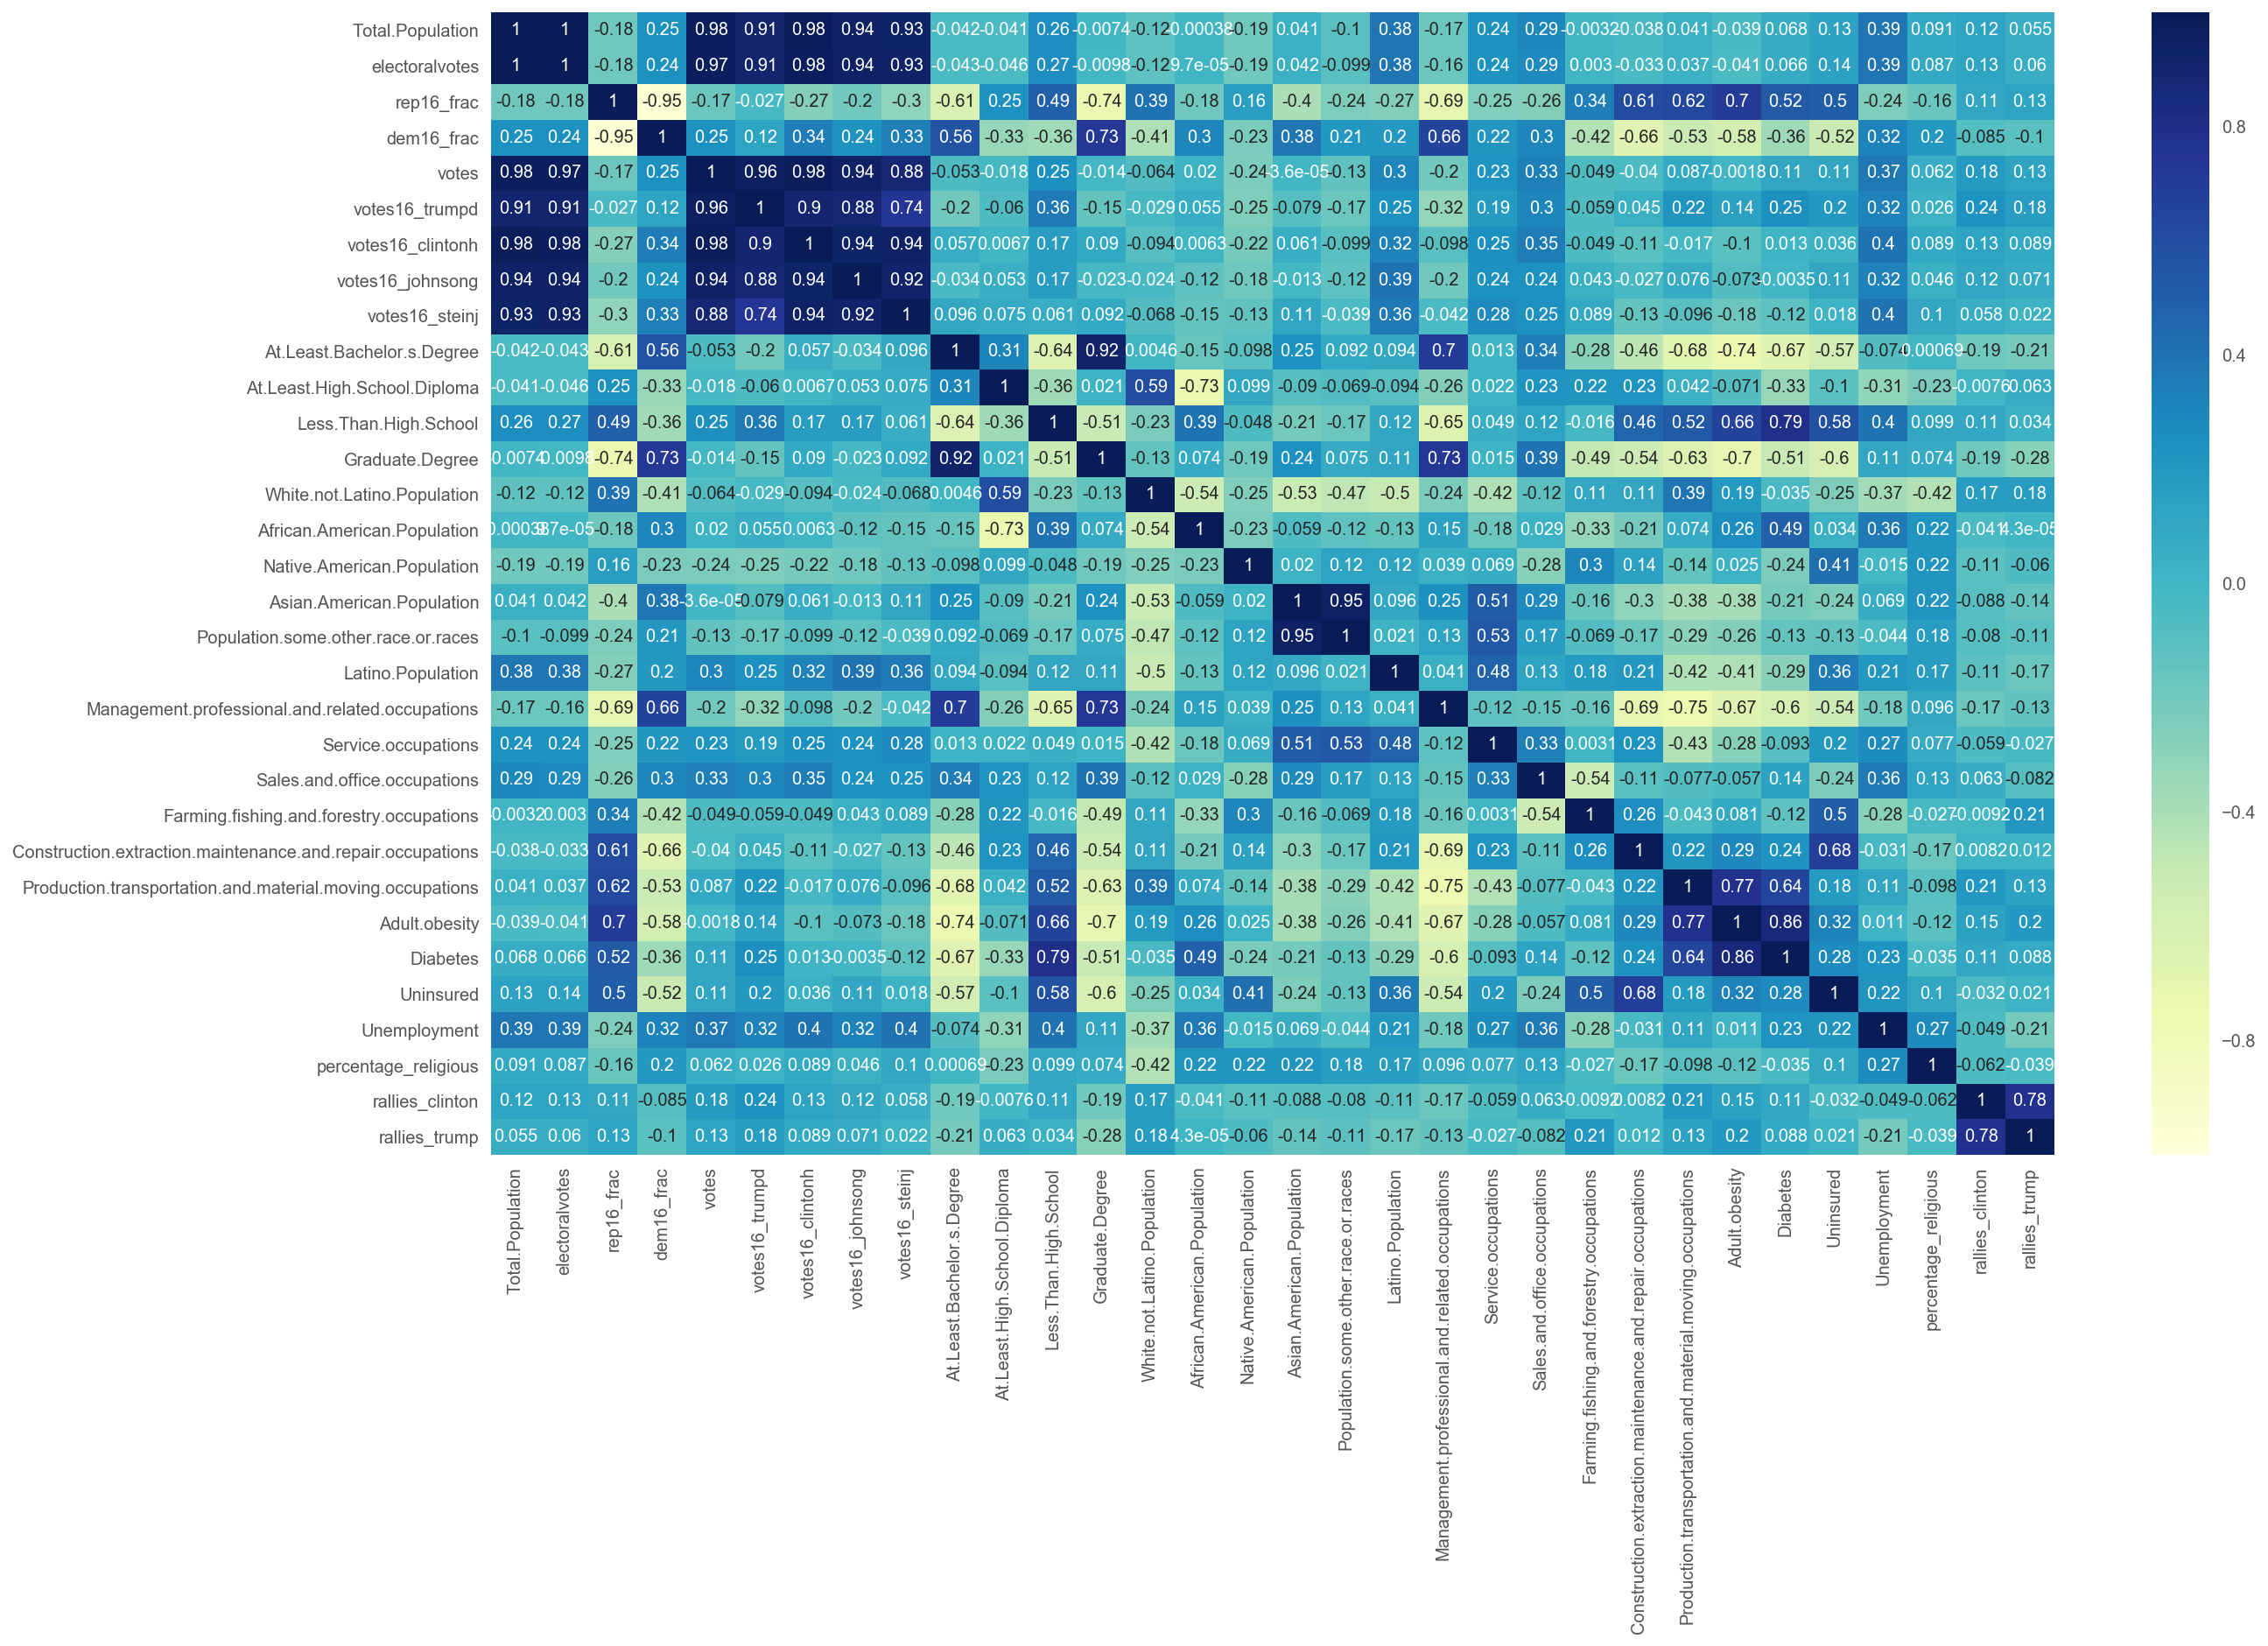

In [36]:
plt.figure(figsize=(20,12))

sns.heatmap(df_merged.corr(), annot=True, cmap='YlGnBu')

# Sentiment Analysis vs. Demographic & Economic Variables

In [2]:
df_tweets_sentiment = pd.read_pickle('../../../../../Downloads/ap_tweets_classified_sentiment.zip')

In [3]:
df_tweets_sentiment = pd.merge(df_tweets_sentiment, pd.get_dummies(df_tweets_sentiment.sentiment), left_index=True, right_index=True)

In [4]:
df_tweets_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584832 entries, 1 to 651062
Data columns (total 38 columns):
tweet_id                 584832 non-null int64
created_at               584832 non-null object
entities_hashtags        584832 non-null object
entities_mentions        584832 non-null object
place_bounding_box       584801 non-null object
country                  584801 non-null object
place_country_code       584801 non-null object
place_full_name          584801 non-null object
place_id                 584801 non-null object
place_name               584801 non-null object
place_place_type         584801 non-null object
place_url                584801 non-null object
favorite_count           584832 non-null int64
geo_coordinates          7094 non-null object
geo_type                 7094 non-null object
text                     584832 non-null object
lang                     584832 non-null object
retweet_count            584832 non-null int64
retweeted                584832 

In [5]:
df_tweets_sentiment_us = df_tweets_sentiment[df_tweets_sentiment.place_country_code == 'US']

In [6]:
df_tweets_sentiment_us['state'] = df_tweets_sentiment_us.place_full_name.apply(lambda x: DSF_helpers.get_state_ABRV(x))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [9]:
df_hillary = df_tweets_sentiment_us[(df_tweets_sentiment_us.about == 1)]
df_hillary['created_at'] = pd.to_datetime(df_hillary['created_at'])
df_hillary = df_hillary.set_index('created_at')

df_trump = df_tweets_sentiment_us[(df_tweets_sentiment_us.about == 0)]
df_trump['created_at'] = pd.to_datetime(df_trump['created_at'])
df_trump = df_trump.set_index('created_at')

df_time_hillary_pos = df_hillary.resample('D').mean().pos #hillary positive
df_time_hillary_neu = df_hillary.resample('D').mean().neu #hillary positive
df_time_hillary_neg = df_hillary.resample('D').mean().neg #hillary positive

df_trump_pos = df_trump.resample('D').mean().pos #trump positive
df_trump_neu = df_trump.resample('D').mean().neu #trump positive
df_trump_neg = df_trump.resample('D').mean().neg #trump positive

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



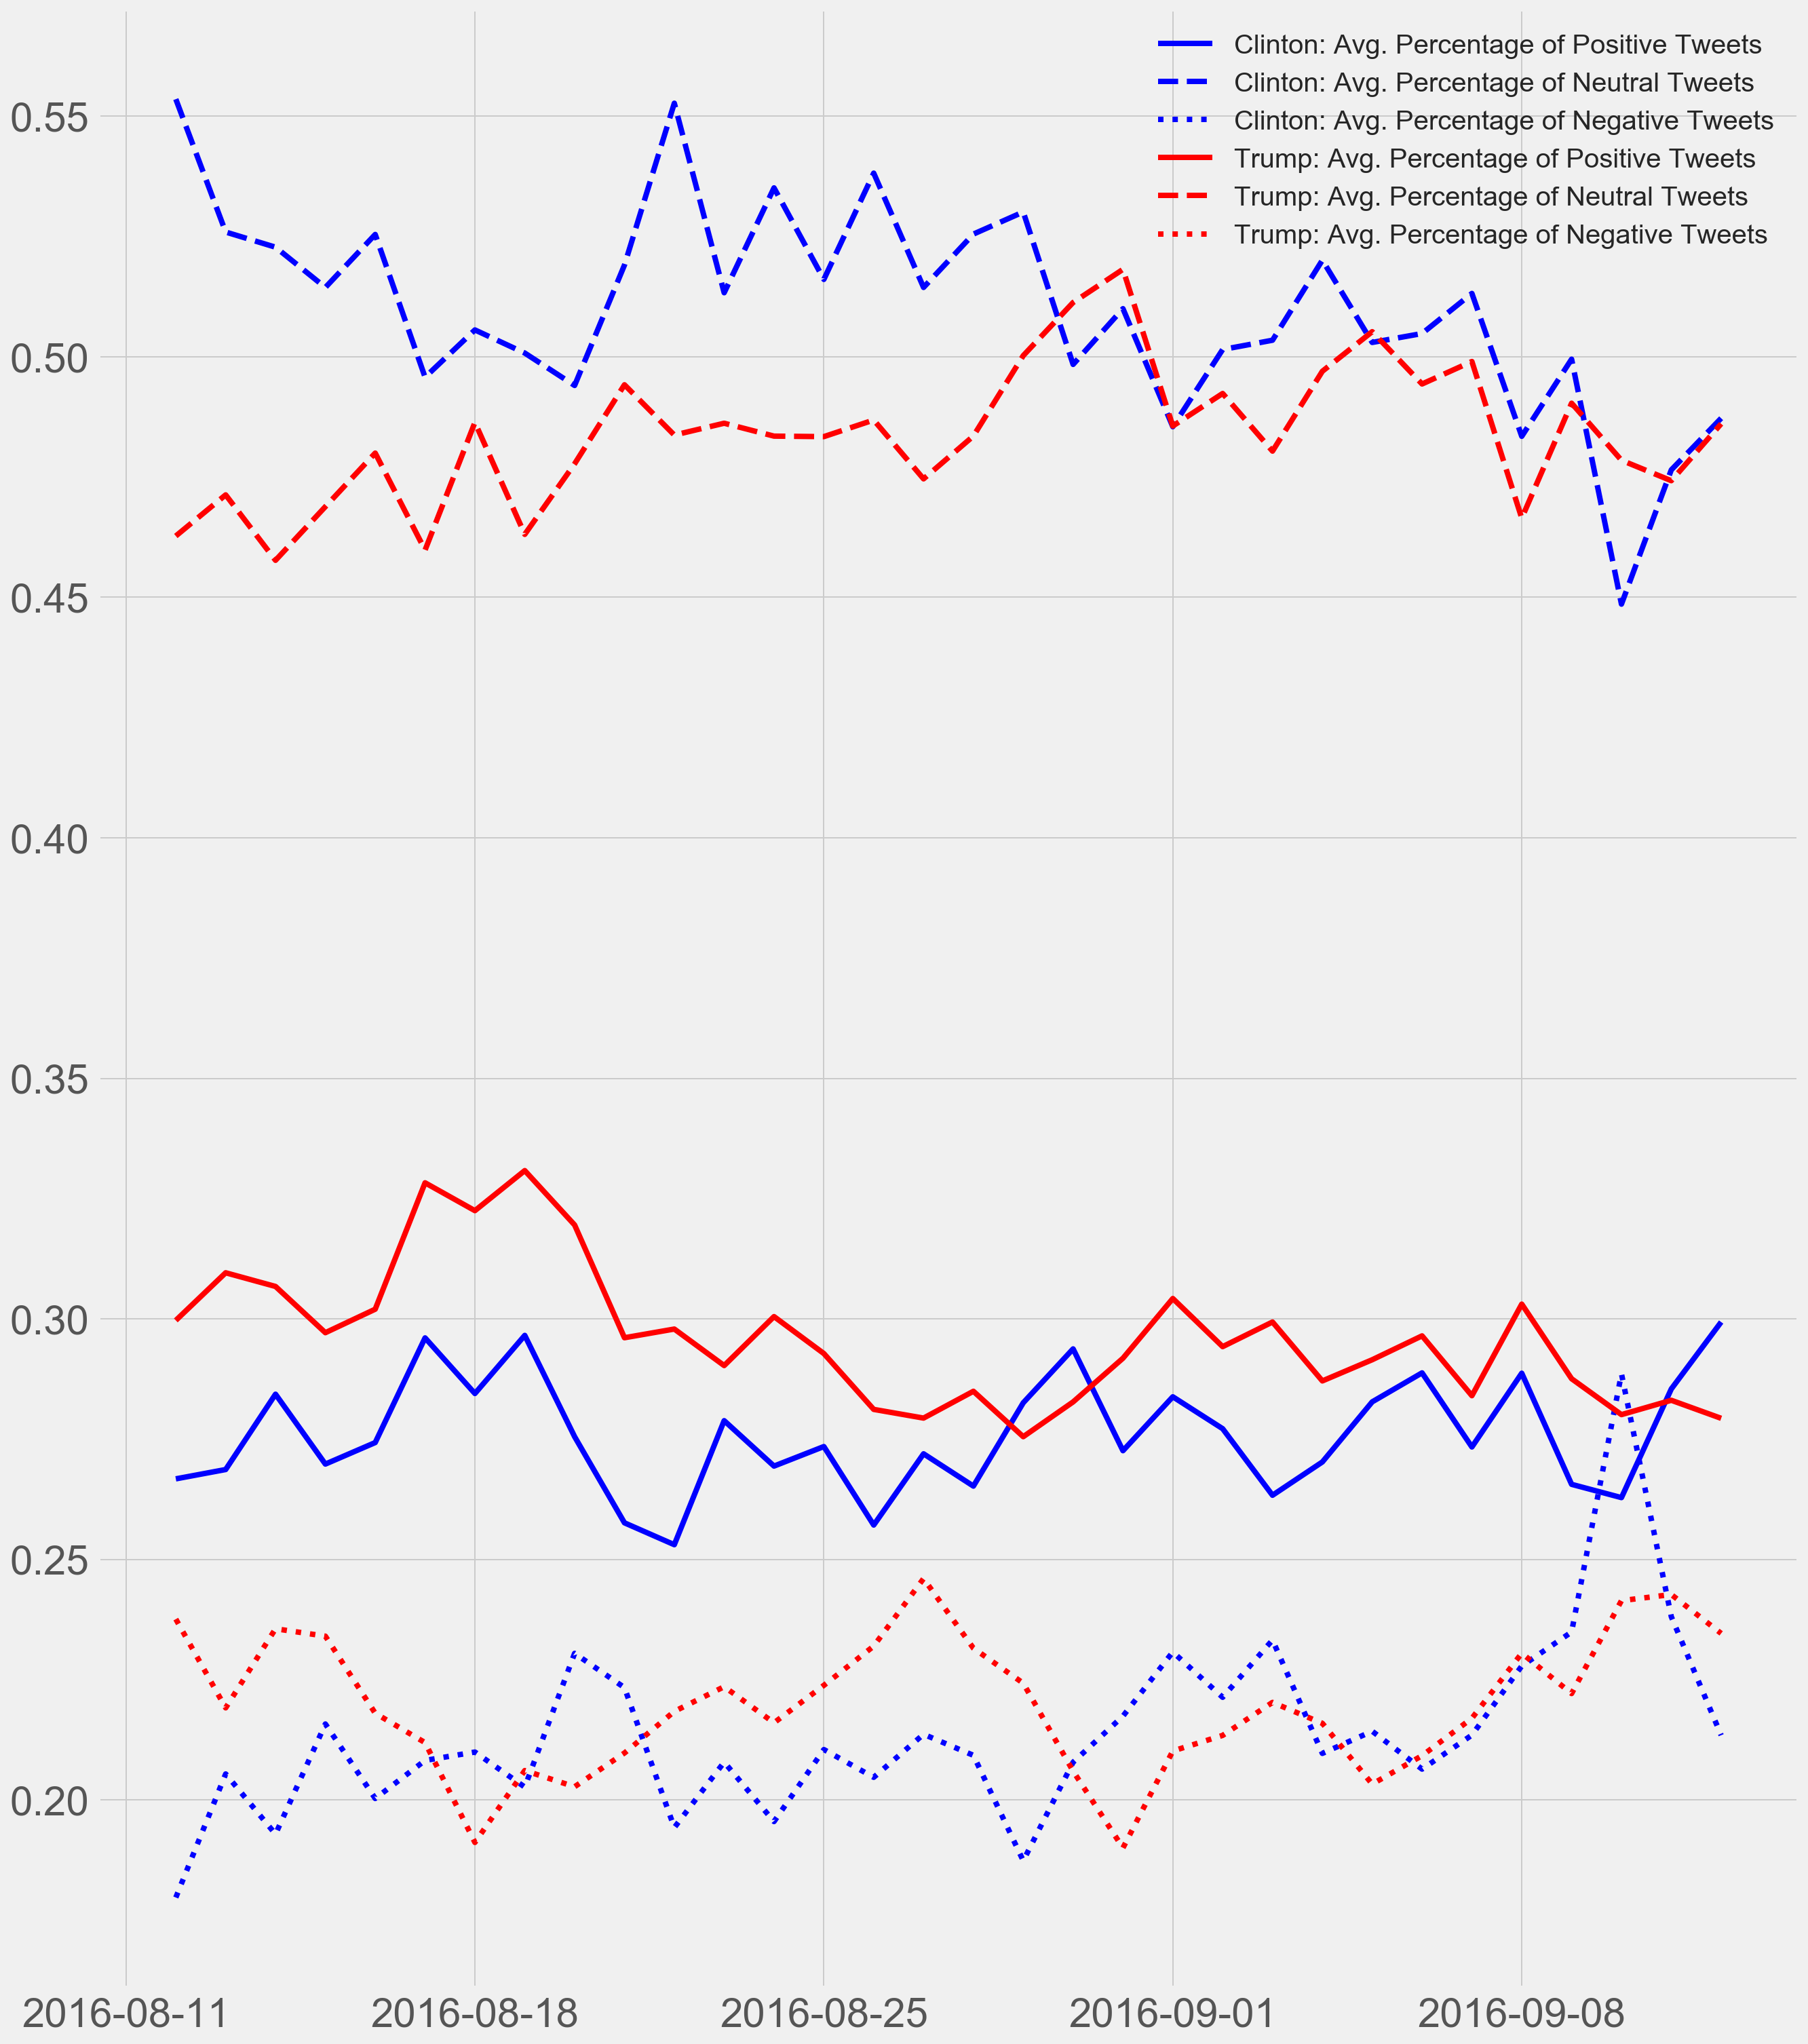

In [51]:
plt.figure(figsize=(20,25))

plt.style.use('fivethirtyeight')

plt.tick_params(labelsize=30)

plt.plot(df_time_hillary_pos, label='Clinton: Avg. Percentage of Positive Tweets', color='blue')
plt.plot(df_time_hillary_neu, '--', label='Clinton: Avg. Percentage of Neutral Tweets', color='blue')
plt.plot(df_time_hillary_neg, ':', label='Clinton: Avg. Percentage of Negative Tweets', color='blue')

plt.plot(df_trump_pos, label='Trump: Avg. Percentage of Positive Tweets', color='red')
plt.plot(df_trump_neu, '--', label='Trump: Avg. Percentage of Neutral Tweets', color='red')
plt.plot(df_trump_neg, ':', label='Trump: Avg. Percentage of Negative Tweets', color='red')

plt.legend(loc=1, prop={'size': 20})

#df_tweets_sentiment_us[(df_tweets_sentiment_us.state.str.len() == 2)].groupby('state').mean()

In [44]:
df_tweets_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584832 entries, 1 to 651062
Data columns (total 38 columns):
tweet_id                 584832 non-null int64
created_at               584832 non-null object
entities_hashtags        584832 non-null object
entities_mentions        584832 non-null object
place_bounding_box       584801 non-null object
country                  584801 non-null object
place_country_code       584801 non-null object
place_full_name          584801 non-null object
place_id                 584801 non-null object
place_name               584801 non-null object
place_place_type         584801 non-null object
place_url                584801 non-null object
favorite_count           584832 non-null int64
geo_coordinates          7094 non-null object
geo_type                 7094 non-null object
text                     584832 non-null object
lang                     584832 non-null object
retweet_count            584832 non-null int64
retweeted                584832 

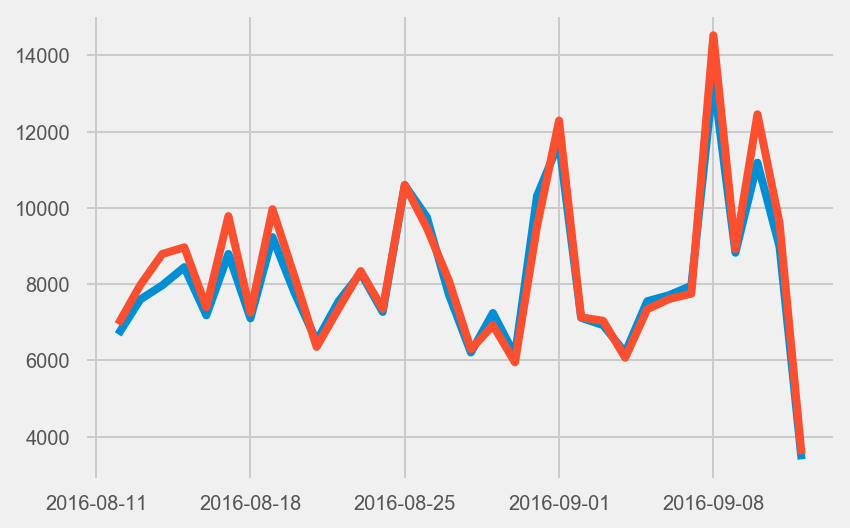

In [84]:
#df_tweets_sentiment_us['created_at'] = pd.to_datetime(df_tweets_sentiment_us['created_at'])
#df_tweets_sentiment_us = df_tweets_sentiment_us.set_index('created_at')

plt.plot((df_tweets_sentiment_us[df_tweets_sentiment_us.sentiment == 'neu']).resample('D').count().neu)
plt.plot((df_tweets_sentiment_us[df_tweets_sentiment_us.sentiment != 'neu']).resample('D').count().neu)

In [ ]:
df_tweets_sentiment_us['state']

In [103]:
df_tweets_sentiment_average_trump = df_tweets_sentiment_us[df_tweets_sentiment_us.about == 0].loc[:, ['neg', 'neu', 'pos', 'state']].groupby('state').mean()
df_tweets_sentiment_average_hillary = df_tweets_sentiment_us[df_tweets_sentiment_us.about == 1].loc[:, ['neg', 'neu', 'pos', 'state']].groupby('state').mean()

In [104]:
df_merged_final = pd.merge(df_tweets_sentiment_average_trump, df_merged, left_index=True, right_on='code', suffixes=['_trump', ''])
df_merged_final = pd.merge(df_tweets_sentiment_average_hillary, df_merged_final, left_index=True, right_on='code', suffixes=['_hillary', ''])

In [105]:
df_merged_final = df_merged_final.rename(columns={'neu': 'neu_trump', 'neg': 'neg_trump', 'pos': 'pos_trump'})

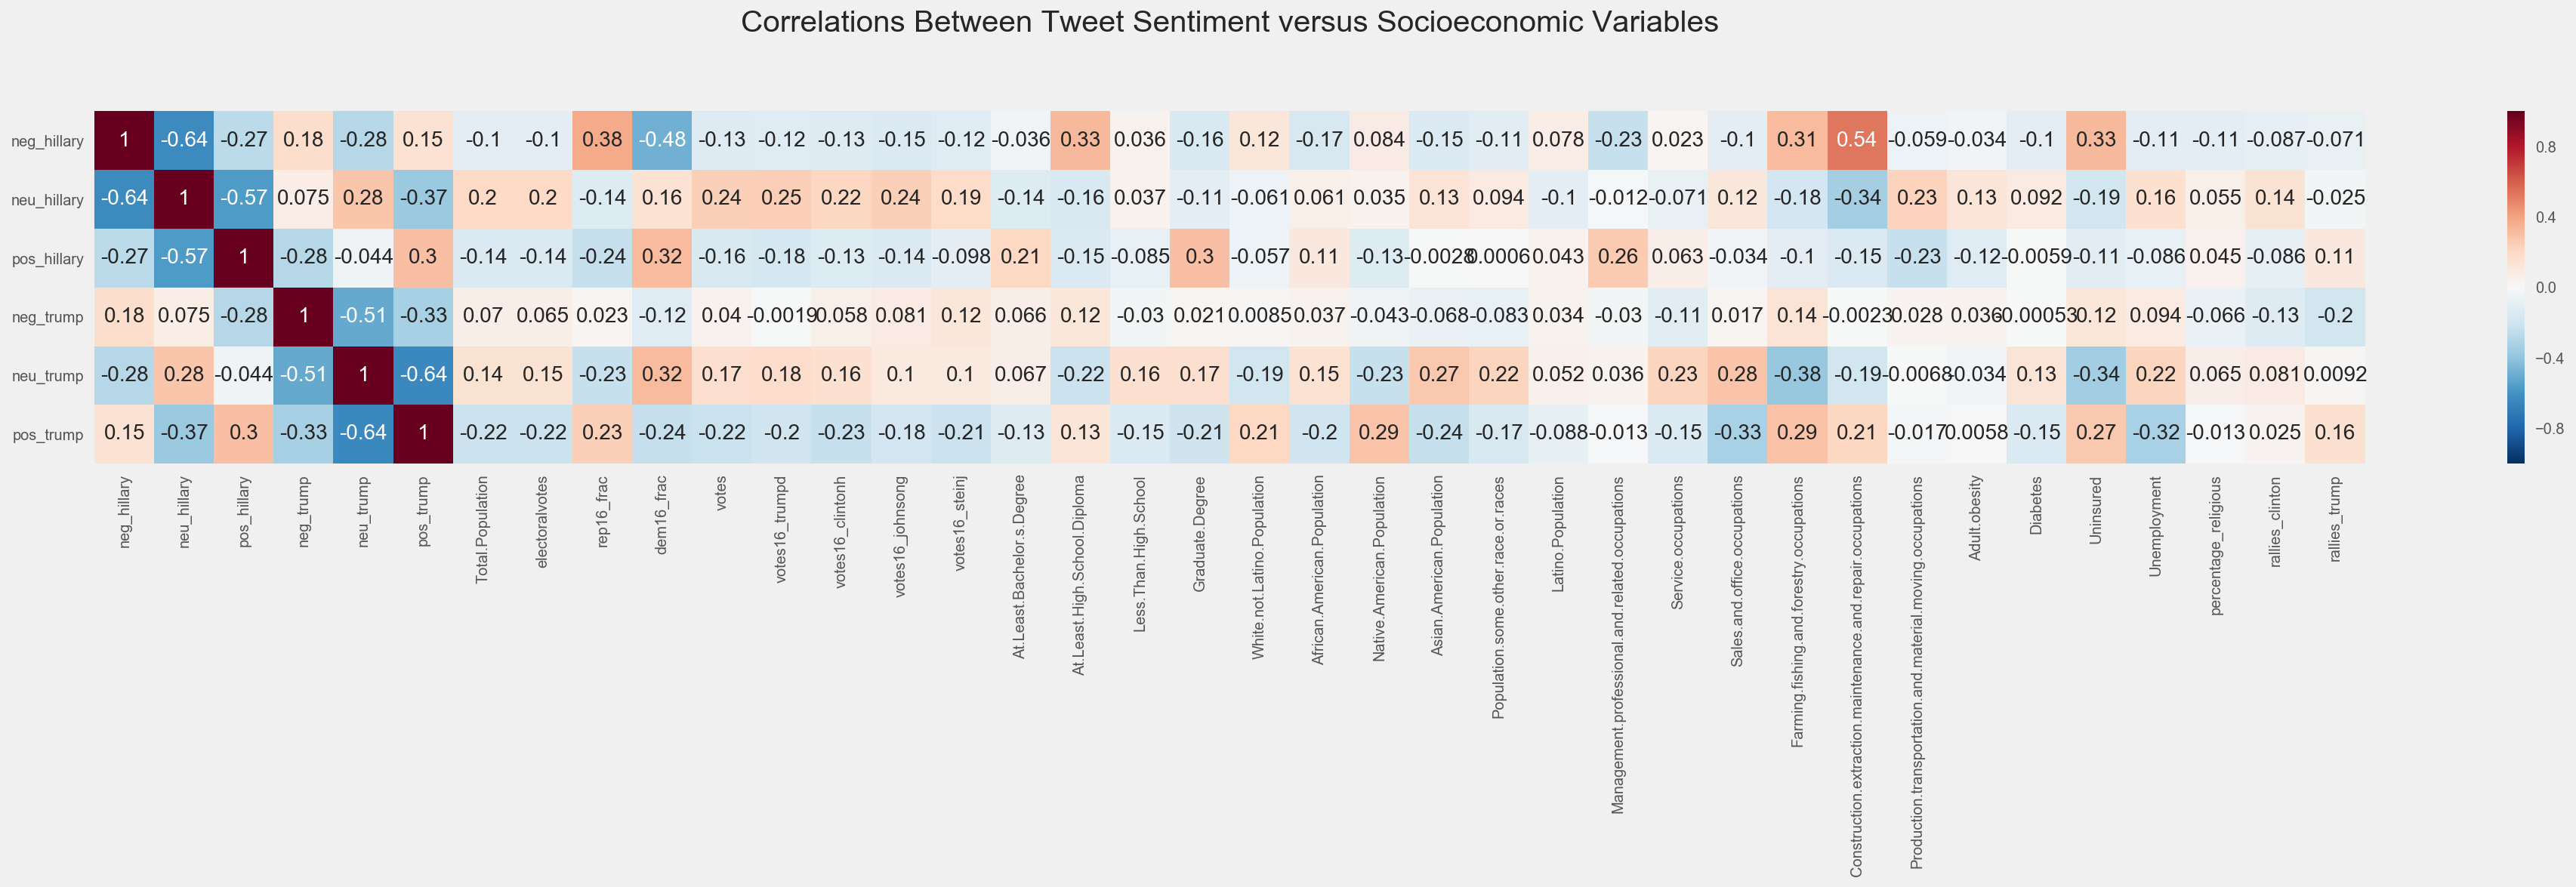

In [115]:
plt.figure(figsize=(30,4))

plt.title('Correlations Between Tweet Sentiment versus Socioeconomic Variables', y=1.2)

sns.heatmap(df_merged_final.corr()[:6], annot=True)

In [93]:
df_merged_final.corr()[:6]

,neg_hillary,neu_hillary,pos_hillary,neg_trump,neu_trump,pos_trumo,Total.Population,electoralvotes,rep16_frac,dem16_frac,...,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,percentage_religious,rallies_clinton,rallies_trump
neg_hillary,1.000000,-0.638841,-0.268359,0.176087,-0.283023,0.153806,-0.101968,-0.102881,0.379576,-0.478377,...,0.313863,0.538694,-0.058752,-0.033735,-0.102741,0.325893,-0.108928,-0.107131,-0.086542,-0.070806
neu_hillary,-0.638841,1.000000,-0.569679,0.074958,0.276494,-0.370006,0.200523,0.202185,-0.135349,0.155028,...,-0.184030,-0.340042,0.232012,0.126701,0.092370,-0.189364,0.161256,0.055469,0.142489,-0.024809
pos_hillary,-0.268359,-0.569679,1.000000,-0.281968,-0.043862,0.298992,-0.142153,-0.143259,-0.236016,0.316923,...,-0.104861,-0.149694,-0.227749,-0.122610,-0.005904,-0.111034,-0.085550,0.044991,-0.085965,0.106705
neg_trump,0.176087,0.074958,-0.281968,1.000000,-0.509731,-0.330554,0.070250,0.064814,0.023284,-0.121041,...,0.136652,-0.002330,0.028007,0.035559,-0.000527,0.119059,0.093543,-0.065610,-0.127616,-0.195139
neu_trump,-0.283023,0.276494,-0.043862,-0.509731,1.000000,-0.643478,0.140844,0.146417,-0.232733,0.317365,...,-0.376900,-0.193835,-0.006793,-0.034148,0.133875,-0.343997,0.218853,0.065151,0.081164,0.009205
pos_trumo,0.153806,-0.370006,0.298992,-0.330554,-0.643478,1.000000,-0.217009,-0.218287,0.234591,-0.240456,...,0.291877,0.214709,-0.017467,0.005823,-0.146393,0.271434,-0.323310,-0.013096,0.024507,0.163523
